<a href="https://colab.research.google.com/github/AJAkil/All-things-AI/blob/master/TF_book_Ch_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 60.8 MB/s eta 0:00:00


In [54]:
from datasets import list_datasets, load_dataset
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import pprint as pp

In [8]:
all_datasets = list_datasets()
len(all_datasets)
all_datasets[:10]

['acronym_identification',
 'ade_corpus_v2',
 'adversarial_qa',
 'aeslc',
 'afrikaans_ner_corpus',
 'ag_news',
 'ai2_arc',
 'air_dialogue',
 'ajgt_twitter_ar',
 'allegro_reviews']

In [13]:
emotions = load_dataset('emotion')

  0%|          | 0/3 [00:00<?, ?it/s]

In [14]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [15]:
train_ds = emotions['train']
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [16]:
print(len(train_ds))
print(train_ds[0])

16000
{'text': 'i didnt feel humiliated', 'label': 0}


In [18]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [19]:
train_ds.column_names

['text', 'label']

In [21]:
print(train_ds['text'][:10])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy', 'ive been feeling a little burdened lately wasnt sure why that was', 'ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny', 'i feel as confused about life as a teenager or as jaded as a year old man', 'i have been with petronas for years i feel that petronas has performed well and made a huge profit', 'i feel romantic too']


In [22]:
def label_int2str(row):
  return emotions['train'].features['label'].int2str(row)

In [23]:
emotions.set_format(type='pandas')
df = emotions['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [24]:
df['label_name'] = df['label'].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


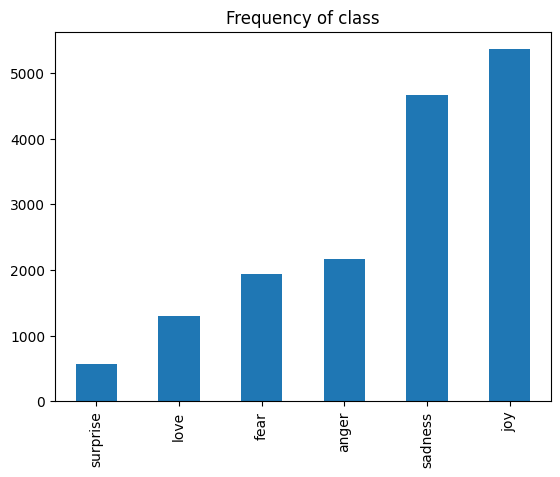

In [27]:
df['label_name'].value_counts(ascending=True).plot.bar()
plt.title('Frequency of class')
plt.show()

In [28]:
df['words_per_tweet'] = df['text'].str.split().apply(len)
df.head()

,text,label,label_name,words_per_tweet
0,i didnt feel humiliated,0,sadness,4
1,i can go from feeling so hopeless to so damned...,0,sadness,21
2,im grabbing a minute to post i feel greedy wrong,3,anger,10
3,i am ever feeling nostalgic about the fireplac...,2,love,18
4,i am feeling grouchy,3,anger,4


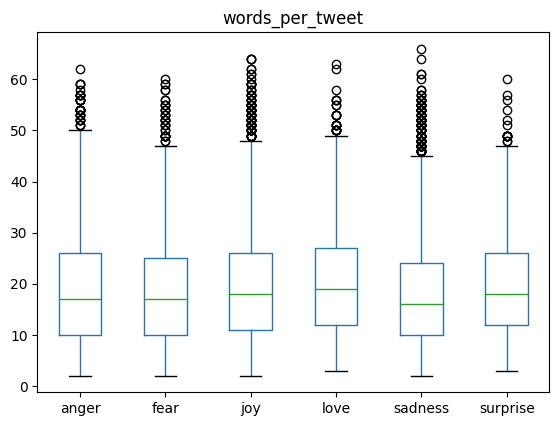

In [32]:
df.boxplot('words_per_tweet', by='label_name', grid=False)
plt.suptitle("")
plt.xlabel("")
plt.show()

# Tokenizations

In [33]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


In [35]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


In [36]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


In [40]:
input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

<ipython-input-40-7f19197ac9a3>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(input_ids)


torch.Size([38, 20])

In [45]:
from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [48]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [50]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
tokens

['[CLS]',
 'token',
 '##izing',
 'text',
 'is',
 'a',
 'core',
 'task',
 'of',
 'nl',
 '##p',
 '.',
 '[SEP]']

In [51]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [55]:
def tokenize(batch):
  return tokenizer(batch['text'], padding=True, truncation=True)

emotions.reset_format()
pp.pprint(tokenize(emotions['train'][:2]))

{'attention_mask': [[1,
                     1,
                     1,
                     1,
                     1,
                     1,
                     1,
                     0,
                     0,
                     0,
                     0,
                     0,
                     0,
                     0,
                     0,
                     0,
                     0,
                     0,
                     0,
                     0,
                     0,
                     0,
                     0],
                    [1,
                     1,
                     1,
                     1,
                     1,
                     1,
                     1,
                     1,
                     1,
                     1,
                     1,
                     1,
                     1,
                     1,
                     1,
                     1,
                     1,
                     1,
               

In [56]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)
print(emotions_encoded['train'].column_names)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

['text', 'label', 'input_ids', 'attention_mask']
